In [65]:
import h5py
from tqdm import tqdm
import librosa
import numpy as np
from keras.utils.np_utils import to_categorical
from sklearn.utils import shuffle
import cv2
import sys
import matplotlib.pyplot as plt

In [66]:
classes13 = {
  "Pipistrellus pipistrellus": 0,
  "Pipistrellus nathusii": 1,
  "Pipistrellus kuhlii": 2,
  "Myotis daubentonii": 3,
  "Nyctalus noctula": 4,
  "Nyctalus leisleri": 5,
  "Eptesicus serotinus": 6,
  "Myotis dasycneme": 7,
  "Miniopterus schreibersii": 8,
  "Vespertilio murinus": 9,
  "Rhinolophus ferrumequinum": 10,
  "Myotis emarginatus": 11,
  "Myotis myotis": 12,
}

classes23 = {
  "Pipistrellus pipistrellus": 0,
  "Pipistrellus nathusii": 1,
  "Pipistrellus kuhlii": 2,
  "Myotis daubentonii": 3,
  "Nyctalus noctula": 4,
  "Nyctalus leisleri": 5,
  "Myotis nattereri": 6,
  "Eptesicus serotinus": 7,
  "Myotis dasycneme": 8,
  "Miniopterus schreibersii": 9,
  "Vespertilio murinus": 10,
  "Rhinolophus ferrumequinum": 11,
  "Rhinolophus hipposideros": 12,
  "Myotis brandtii": 13,
  "Myotis mystacinus": 14,
  "Myotis emarginatus": 15,
  "Myotis myotis": 16,
  "Pipistrellus pygmaeus": 17,
  "Hypsugo savii": 18,
  "Eptesicus nilssonii": 19,
  "Tadarida teniotis": 20,
  "Myotis capaccinii": 21,
  "Pipistrellus maderensis": 22,
  "Rhinolophus blasii": 23
}

labels = classes13

In [67]:
prepared_hf = h5py.File('prepared.h5', 'r')

In [68]:
sample_rate = 22050                          # recordings are in 96 kHz, 24 bit depth, 1:10 TE (mic sr 960 kHz), 22050 Hz = 44100 Hz TE
n_fft = 512                                  # 23 ms * 22050 Hz
frame_rate = int(sample_rate / (n_fft // 4)) # 22050 / 128 ~ 172

patch_len = 44                               # = 250ms ~ 25ms

scale_factor = 1.0

In [69]:
def peak_detect(spectrogram):
  env = np.mean(spectrogram, axis=1)
  peaks = librosa.util.peak_pick(env, pre_max=3, post_max=5, pre_avg=3, post_avg=5, delta=0.6, wait=20)
  return env, peaks

def getIndividuals(spectrogram):
  individuals = []
  _, peaks = peak_detect(spectrogram)
  for p in peaks:
    pos = p - int(patch_len / 2)
    individuals.append(spectrogram[pos:pos+patch_len])
  return individuals

In [70]:
set = "val"
prepared_set = prepared_hf.require_group(set)

X_ind = []
Y_ind = []
print("Preparing " + set + " dataset.")

Preparing val dataset.


In [71]:
for species in tqdm(list(labels)):
  S_db = np.asarray(prepared_set.get(species))
  new_size = (int(S_db.shape[1] * scale_factor), int(S_db.shape[0] * scale_factor))
  S_db = cv2.resize(S_db, dsize=new_size, interpolation=cv2.INTER_NEAREST)
  label = to_categorical(labels[species], num_classes=len(labels)) # one hot encoding

  ind = getIndividuals(S_db)
  X_ind.extend(ind)
  Y_ind.extend([label] * len(ind))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:03<00:00,  3.60it/s]


In [72]:
print("Individuals:", len(X_ind))
print("Shuffling...")
X_ind, Y_ind = shuffle(X_ind, Y_ind, random_state=42)

Individuals: 7045
Shuffling...


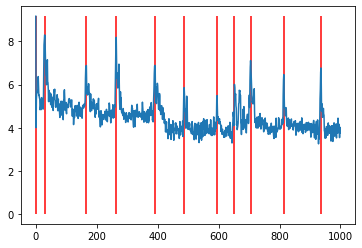

In [73]:
# REMOVE LATER
S_db = np.asarray(prepared_set.get("Myotis daubentonii"))
new_size = (int(S_db.shape[1] * scale_factor), int(S_db.shape[0] * scale_factor))
S_db = cv2.resize(S_db, dsize=new_size, interpolation=cv2.INTER_NEAREST)

spec = S_db[:1000]
individuals = []
env = np.mean(spec, axis=1)
peaks = librosa.util.peak_pick(env, pre_max=3, post_max=5, pre_avg=3, post_avg=5, delta=0.6, wait=20)
plt.plot(env)
plt.vlines(peaks, 0, env.max(), color='r')
for p in peaks:
  pos = p - int(patch_len / 2)
  individuals.append(spec[pos:pos+patch_len])

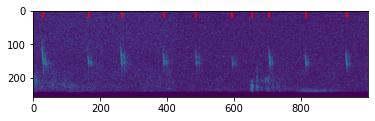

In [74]:
# REMOVE LATER
plt.imshow(np.rot90(spec))
plt.vlines(peaks, 0, 20, color='r')

In [75]:
def plot_patch(patch, y):
  plt.figure(figsize = (5, 10))
  spec = np.rot90(patch)
  plt.imshow(spec, interpolation='nearest', aspect='auto', cmap='inferno')
  plt.colorbar()
  plt.title(list(labels)[np.argmax(y)])

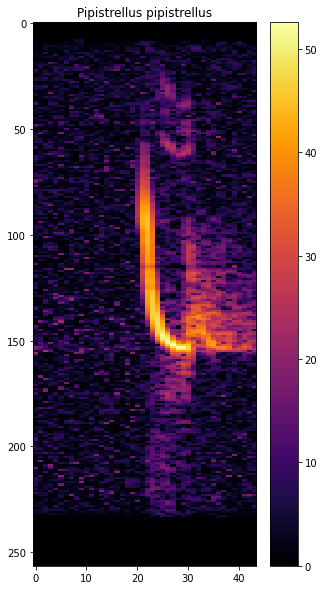

In [79]:
plot_patch(X_ind[0], Y_ind[0])